# Video lifetime performance prediction based on early engagement signals

## I. Exploring the feature set

### Dataset Structure and Feature Overview

This dataset is designed to capture video performance and early engagement signals around platform-specific impression milestones.

Key Feature Groups:
- `video_id`, `channel_name`, `video_length`: basic identifiers and metadata
- `*_1k`: engagement metrics when the video reaches 1,000 impressions (e.g., `views3s_1k`, `like_1k`, `comments_1k`)
- `*_5k`: engagement metrics at the 5,000 impression milestone (e.g., `views3s_5k`, `like_5k`, `comments_5k`)
- `*_final`: final outcome metrics used as regression targets (e.g., `views_final`, `like_final`, `comment_final`)
- `reaches_5k`: boolean flag indicating whether the video truly reached 5k impressions

These features reflect the kind of early-stage metrics typically available in video performance forecasting workflows.

In [45]:
# Import libraries
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

In [46]:
# Load the dataset
file_path = '../data/video_dataset.csv'
df = pd.read_csv(file_path)
df.shape

(10000, 16)

In [47]:
df.head()

,video_id,channel_name,video_length,views_final,impressions_final,like_final,comment_final,views3s_1k,impressions_1k,like_1k,comments_1k,views3s_5k,impressions_5k,like_5k,comments_5k,reaches_5k
0,cdfc697c-057d-45d6-b99b-6bf76ae32f2a,channel_912,535,561,4551,23,3,183,1000,4,1,226,5000,3,0,False
1,f88f61b8-29f8-4e1d-b303-2c775859e473,channel_908,591,634,12638,17,1,72,1000,1,0,133,5000,7,0,True
2,7f2db174-192e-4045-88aa-eaca6233d732,channel_301,1264,825,9751,54,5,123,1000,4,0,248,5000,5,0,True
3,af52e3f6-e867-4556-ab92-76b995115f70,channel_849,706,646,4739,15,6,197,1000,15,1,323,5000,10,0,False
4,7e74d4a7-968f-41f6-a2e2-20779d6e2a45,channel_853,184,482,9019,31,4,72,1000,1,0,108,5000,6,0,True


## II. Exploring the target distribution

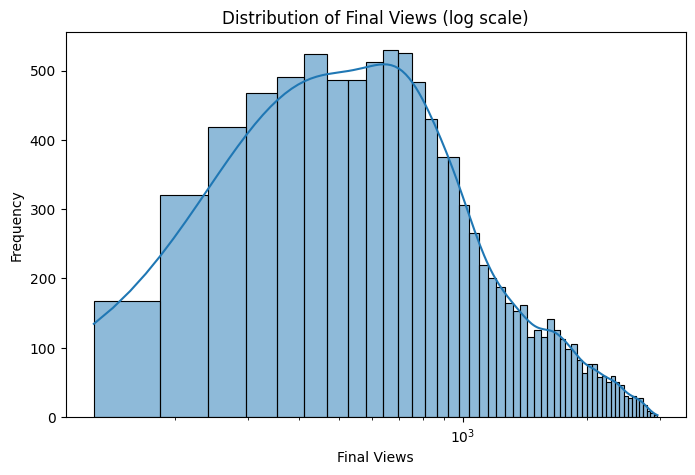

In [48]:
# Histogram of final views
plt.figure(figsize=(8, 5))
sns.histplot(df['views_final'], bins=50, kde=True)
plt.xscale("log")
plt.title("Distribution of Final Views (log scale)")
plt.xlabel("Final Views")
plt.ylabel("Frequency")
plt.show()

### Final Views Distribution (Log Scale)

The right-skewed distribution becomes more normalized on a log scale, as expected in view-count datasets. Most videos cluster in the lower range, with a long tail of highly popular (viral) videos. This confirms the synthetic data retains platform realism and supports regression modeling.

## III. Testing which features are tied closely to final outcome with correlations

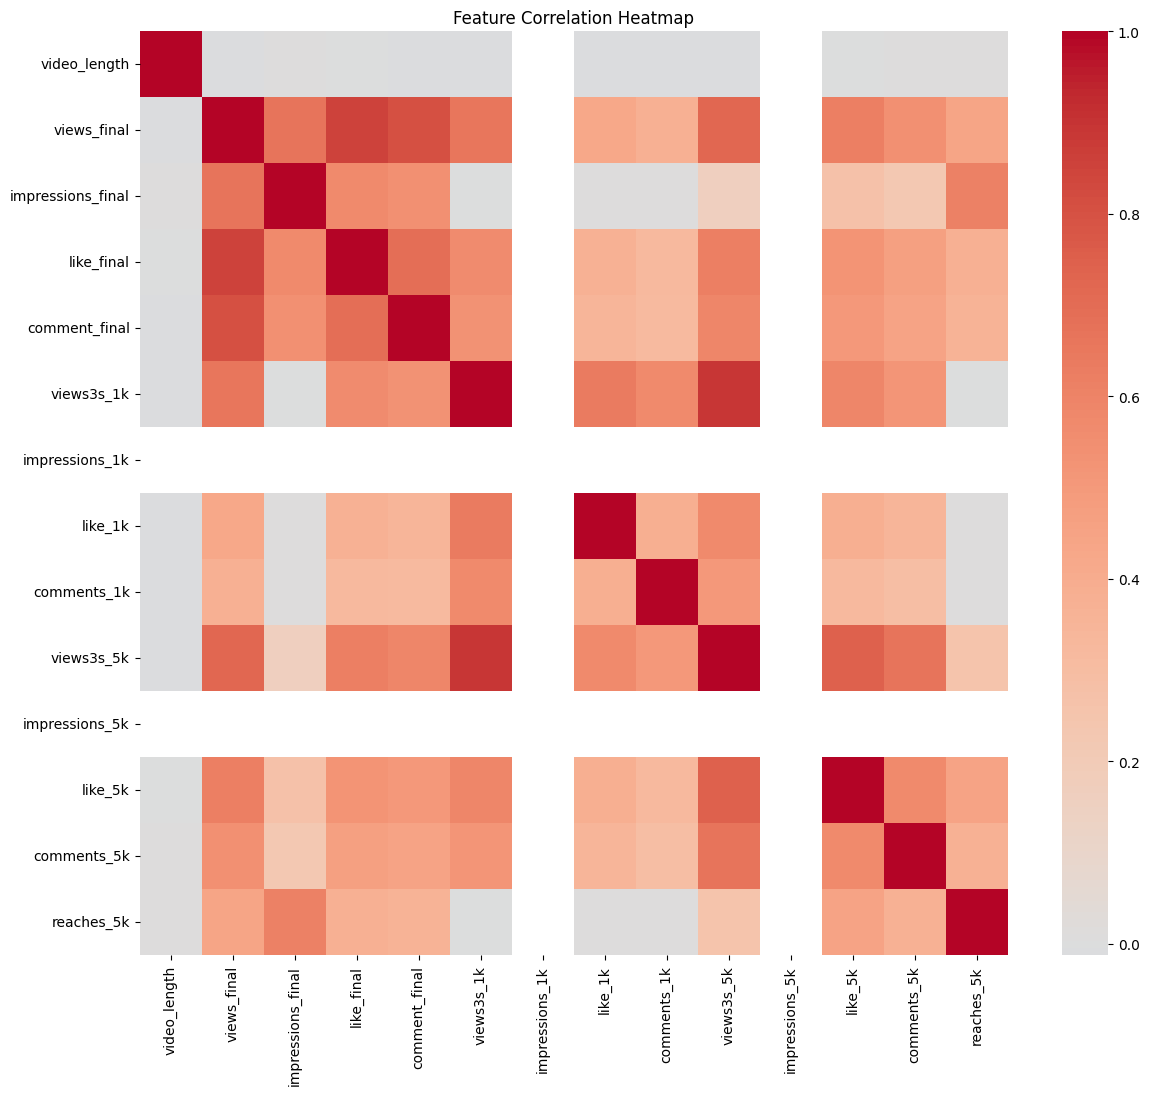

In [49]:
# Feature correlation heatmap
numeric_cols = [col for col in df.columns if df[col].dtype != 'object' and col != 'video_id']
corr = df[numeric_cols].corr()

plt.figure(figsize=(14, 12))
sns.heatmap(corr, cmap="coolwarm", center=0)
plt.title("Feature Correlation Heatmap")
plt.show()

### Feature Correlation Summary

Final view metrics are strongly associated with early engagement signals at both 1k and 5k milestones. Metrics within each milestone form clusters, and the lifespan trigger variable (`reaches_5k`) behaves as expected. Weak features like `video_length` and `comments` do not correlate strongly with outcomes.

In [50]:
# Save processed numeric feature list
numeric_features = [col for col in numeric_cols if col != 'views_final']
with open("../src/numeric_features.txt", "w") as f:
    for col in numeric_features:
        f.write(f"{col}\n")

## IV. Training a regression model

### Initial Model Training: Baseline Approach

We begin with a single Random Forest model trained on log-transformed `views_final`. This gives us a baseline against which to compare more advanced techniques like lifespan-aware modeling.

In [51]:
# Train a basic regression model
from sklearn.model_selection import train_test_split
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_absolute_error, mean_absolute_percentage_error

In [52]:
# Select early features
features = [
    'views3s_1k', 'like_1k', 'comments_1k', 'impressions_1k',
    'views3s_5k', 'like_5k', 'comments_5k', 'impressions_5k',
    'video_length'
]

In [53]:
# Create X and y and split the data
X = df[features]
y_log = np.log1p(df['views_final'])

X_train, X_test, y_train_log, y_test_log = train_test_split(X, y_log, test_size=0.2, random_state=42)

In [54]:
# Fit the model
model = RandomForestRegressor(n_estimators=100, random_state=42)
model.fit(X_train, y_train_log)

RandomForestRegressor(random_state=42)

In [55]:
# Evaluate
y_pred_log = model.predict(X_test)
y_pred_exp = np.expm1(y_pred_log)
y_test_exp = np.expm1(y_test_log)

mae = mean_absolute_error(y_test_exp, y_pred_exp)
mape = mean_absolute_percentage_error(y_test_exp, y_pred_exp)

print(f"MAE: {mae:.2f}")
print(f"MAPE: {mape:.4f}")

MAE: 276.70
MAPE: 0.3101


### Evaluation of Baseline Model

The single-model approach delivers an average error (MAE) of ~270 views and a MAPE of ~31%. This is a good baseline, but it does not account for differences in how fast or slow videos reach their final popularity. We now explore modeling based on video lifespan groups.

## V. Introduce cluster-specific modelling

### Lifespan Classification: LARM Step 1

We segment videos by **view velocity**, or how fast they accumulate views. We define:

- `long`: ≥ 50% of final views already captured at 5k impressions
- `short`: < 50% of final views captured at 5k impressions or no 5k data

These two groups represent different video popularity curves and will benefit from separate regressors.

In [56]:
# Estimate alpha-lifespan and cluster
def classify_lifespan(row, alpha=0.5):
    if pd.isna(row['views3s_5k']):
        return 'short'
    ratio = row['views3s_5k'] / row['views_final']
    return 'long' if ratio >= alpha else 'short'

df['lifespan_group'] = df.apply(classify_lifespan, axis=1)

In [57]:
df['lifespan_group'].value_counts()

lifespan_group
short    7634
long     2366
Name: count, dtype: int64

In [58]:
# Train separate models for each lifespan group
models = {}
metrics = {}

for group in ['short', 'long']:
    group_df = df[df['lifespan_group'] == group]
    X = group_df[features]
    y_log = np.log1p(group_df['views_final'])

    X_train, X_test, y_train, y_test = train_test_split(X, y_log, test_size=0.2, random_state=42)
    model = RandomForestRegressor(n_estimators=100, random_state=42)
    model.fit(X_train, y_train)

    y_pred = model.predict(X_test)
    y_pred_exp = np.expm1(y_pred)
    y_test_exp = np.expm1(y_test)

    mae = mean_absolute_error(y_test_exp, y_pred_exp)
    mape = mean_absolute_percentage_error(y_test_exp, y_pred_exp)

    models[group] = model
    metrics[group] = {'MAE': mae, 'MAPE': mape}

In [59]:
# Compare specialized models
for group in metrics:
    print(f"{group.title()} Lifespan Model")
    print(f"MAE: {metrics[group]['MAE']:.2f}")
    print(f"MAPE: {metrics[group]['MAPE']:.4f}\n")

Short Lifespan Model
MAE: 237.45
MAPE: 0.2379

Long Lifespan Model
MAE: 53.65
MAPE: 0.0963



### Final Takeaways

1. **Lifespan-aware modeling significantly outperforms global models**.
   - The `long` lifespan model achieved an MAE of just 54 and a MAPE under 10%.
   - By contrast, the global model had ~31% MAPE.

2. **Short lifespan videos are inherently harder to predict early**.
   - Their performance develops more gradually or unpredictably beyond early milestones.

3. **Growth velocity is a meaningful segmentation variable**.
   - Simple clustering based on early view ratios allows more accurate modeling.

This validates the LARM paper’s hypothesis: forecasting lifetime video performance benefits from grouping content by view accumulation pace. We’ve shown that even with milestone-based synthetic data, this approach yields significant performance improvements.

## This dataset was structured around impression-based milestones, not time. While this supports analysis of engagement quality at fixed exposure points, it prevents true early-stage forecasting without timestamp data